<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/matched_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Matched Filtering with Chirp Transform
#####(Testing) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).

##### Code *Reference*:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)

In [1]:
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3'

     |████████████████████████████████| 28.5 MB 1.5 MB/s 
     |████████████████████████████████| 3.1 MB 20.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 30.1 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 75 kB 2.0 MB/s 
     |████████████████████████████████| 201 kB 57.8 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 3.6 MB 39.5 MB/s 


#### Examples: ODW 2020

In [2]:
%matplotlib inline
import numpy
import pylab

# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

Text(0, 0.5, 'Normalized amplitude')

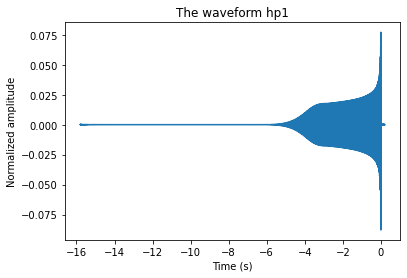

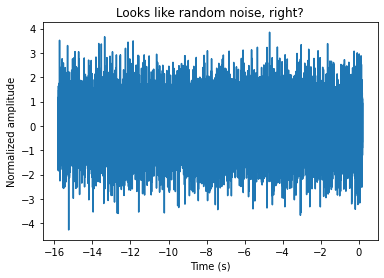

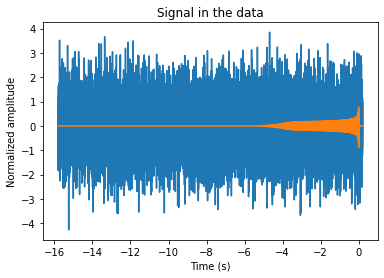

In [3]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform
# but here, we'll use defaults for everything except the masses.
# It returns both hplus and hcross, but we'll only use hplus for now.
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

# The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
# on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
# itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
# noise as a signal-to-noise ratio.

hp1 = hp1 / max(numpy.correlate(hp1,hp1, mode='full'))**0.5

# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.
pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

##### Cross-corelation in the time domain

Text(0, 0.5, 'Cross-correlation')

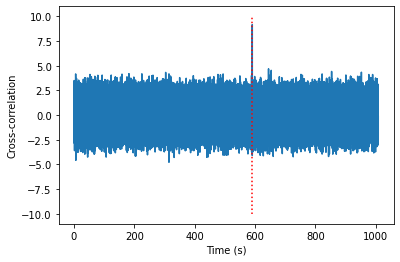

In [4]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

##### Colored LIGO Noise

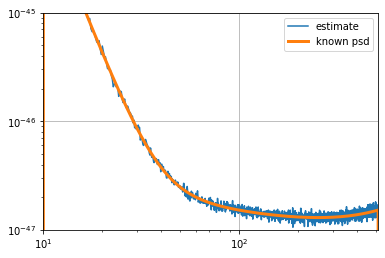

In [5]:
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.legend()
pylab.grid()
pylab.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

In [6]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template. 
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

Text(0, 0.5, 'Cross-correlation')

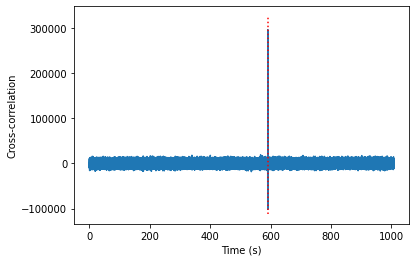

In [7]:
# Now let's re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

# plot the cross-correlation in the time domain. Superimpose the location of the end of the signal.
# Note how much bigger the cross-correlation peak is, relative to the noise level,
# compared with the unwhitened version of the same quantity. SNR is much higher!
pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

#### Reference: ODW 2020 Matched Filtering in Action


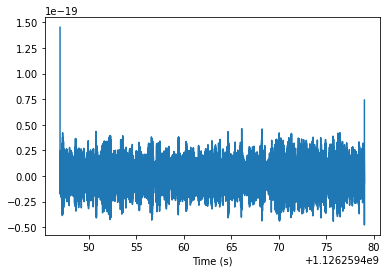

In [8]:
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

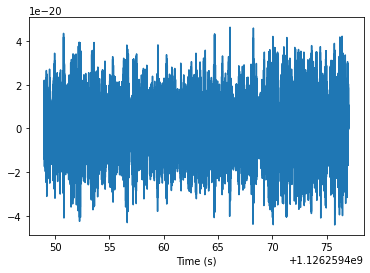

In [9]:

# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [10]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

Text(0, 0.5, 'Strain')

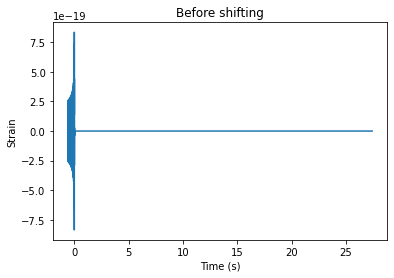

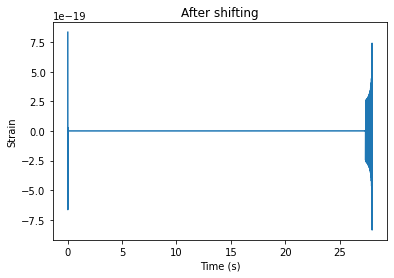

In [11]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

##### Signal to Noise Time Series


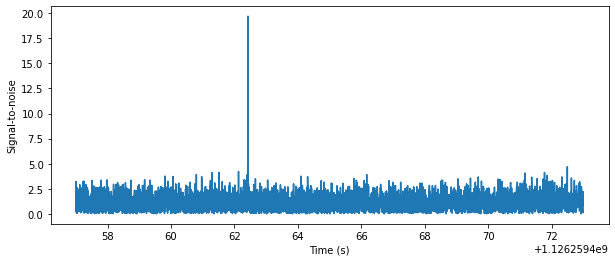

We found a signal at 1126259462.4248047s with SNR 19.677089013145903


In [12]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [13]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

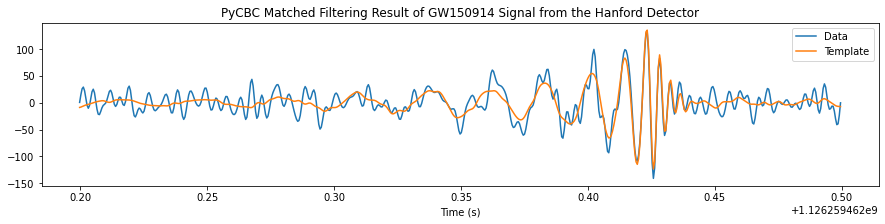

In [15]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.title('PyCBC Matched Filtering Result of GW150914 Signal from the Hanford Detector')
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

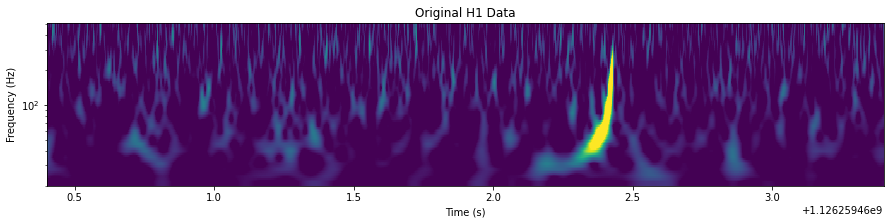

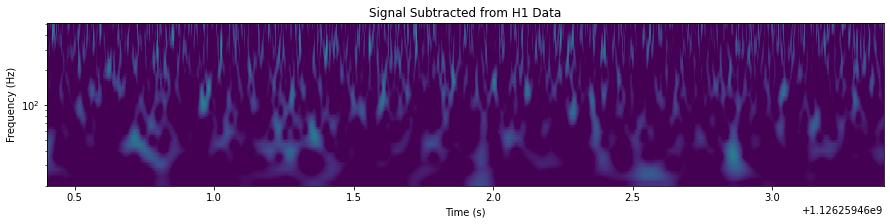

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

#### End of ODW 2020 Examples